First, we'll begin by installing and importing the necessary libraries.

In [1]:
# Importing necessary libraries
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import TensorFlow and Keras components
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
%cd gdrive/MyDrive/

/content/gdrive/MyDrive


In [4]:
# Setting some variables for plotting via matplotlib
plt.rcParams["figure.figsize"] = (12, 12)  # Adjust the size as needed
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('lines', linewidth=3)
plt.rc('font', size=15)

Below, I'm setting random seeds to improve reproducibility, though complete consistency isn't guaranteed due to TensorFlow's inherent non-determinism.

In [5]:
seed_value = 42  # Choose a seed value

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [6]:
import tensorflow as tf

# Check TensorFlow GPU support
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available, using the CPU instead.")

No GPU available, using the CPU instead.


In the next few cells, we'll be handling the organization of JPEG image files from the disk. The images are stored in directories categorized by diagnosis (NORMAL and PNEUMONIA) and by use case (test, train, val), facilitating easy label assignment.

Note that the PNEUMONIA category includes subtypes (bacterial and viral), visible in the filenames, but for this analysis, we'll focus solely on a binary classification: NORMAL vs. PNEUMONIA.

We won't load the images into memory at this stage. Instead, we'll use ImageDataGenerator objects during training to manage images of size 512 x 512 x 1, as loading the entire dataset at once is impractical. Currently, we are just setting up lists of image paths and corresponding string labels, which are necessary for the flow_from_dataframe method of ImageDataGenerator, used later.

In [7]:
def load_image_paths_and_labels(directory, label):
    """
    Load image paths from specified directories and create corresponding labels.

    Args:
    directory (str): Base directory path containing test, train, and val subdirectories.
    label (str): Label to assign to all images from these directories.

    Returns:
    list: List of all image paths.
    list: List of labels corresponding to the image paths.
    """
    subdirs = ['test', 'train', 'val']
    image_paths = []
    for subdir in subdirs:
        full_dir = os.path.join(directory, subdir, label)
        paths = sorted(glob.glob(os.path.join(full_dir, '**/*.jpeg'), recursive=True))
        image_paths.extend(paths)

    labels = [label] * len(image_paths)
    return image_paths, labels

# Directories for normal and pneumonia images
base_directory = 'data/chest-xray-pneumonia/chest_xray/'
normal_label = 'NORMAL'
pneumonia_label = 'PNEUMONIA'

# Load normal and pneumonia image paths and labels
image_paths_norm, labels_norm = load_image_paths_and_labels(base_directory, normal_label)
image_paths_pn, labels_pn = load_image_paths_and_labels(base_directory, pneumonia_label)

In [8]:
# Merge the image and label lists together and turn them into NumPy arrays
image_paths = np.array(image_paths_norm + image_paths_pn)
labels = np.concatenate((labels_norm, labels_pn))

The dataset shows a predominant distribution of pneumonia samples, making up about 73% of the total. This significant representation should facilitate the model's ability to learn to identify pneumonia effectively, potentially eliminating the need for adjusting class weights. Below is a bar plot illustrating this distribution.

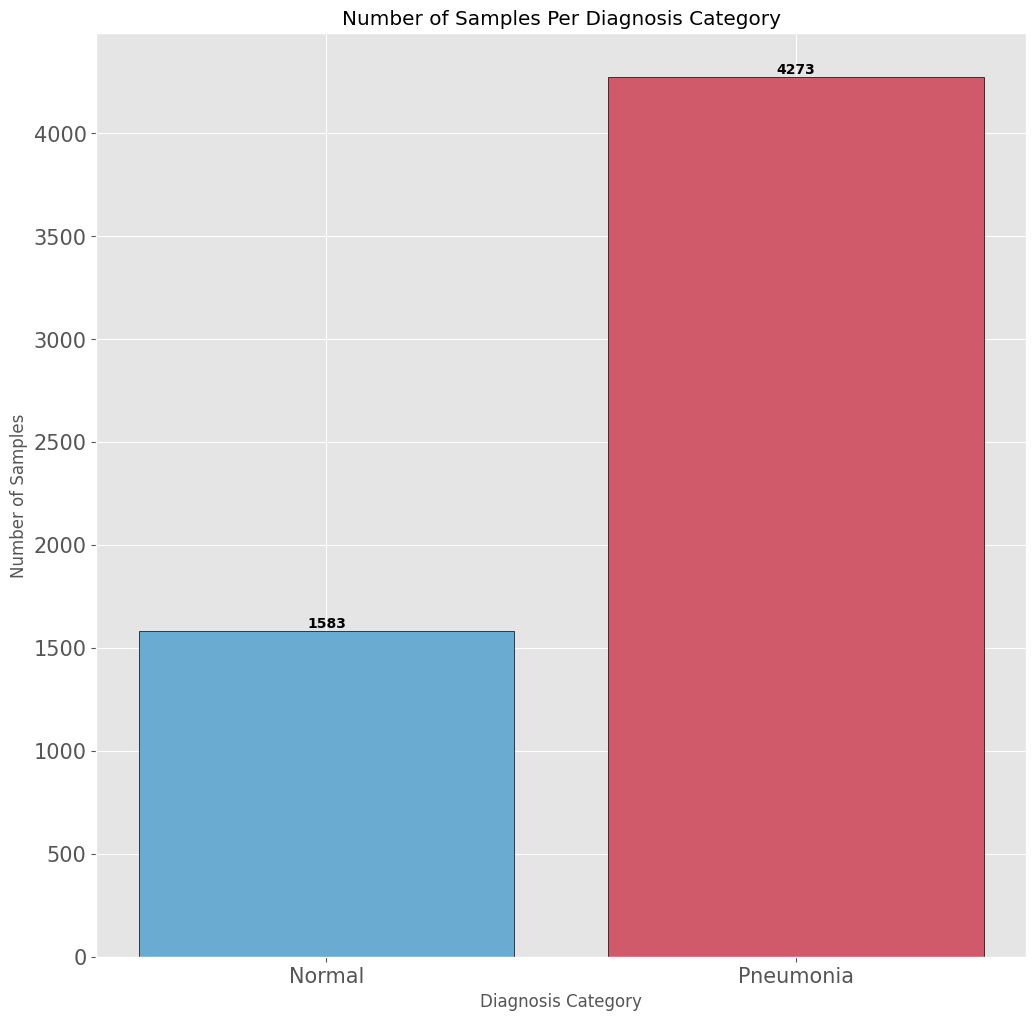

In [9]:
# Setting a style
plt.style.use('ggplot')

# Data for plotting
categories = ['Normal', 'Pneumonia']
values = [len(labels_norm), len(labels_pn)]
colors = ['#6aabd1', '#d15a6a']  # Using color hex codes for better control

# Creating the bar plot
fig, ax = plt.subplots()
bars = ax.bar(categories, values, color=colors, edgecolor='black')

# Adding a title and labels
ax.set_title('Number of Samples Per Diagnosis Category')
ax.set_xlabel('Diagnosis Category')
ax.set_ylabel('Number of Samples')

# Adding text annotations to the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', va='bottom', ha='center', fontweight='bold')

# Showing the plot
plt.show()

Now, let's plot a couple of images from each diagnosis to see how they look like.

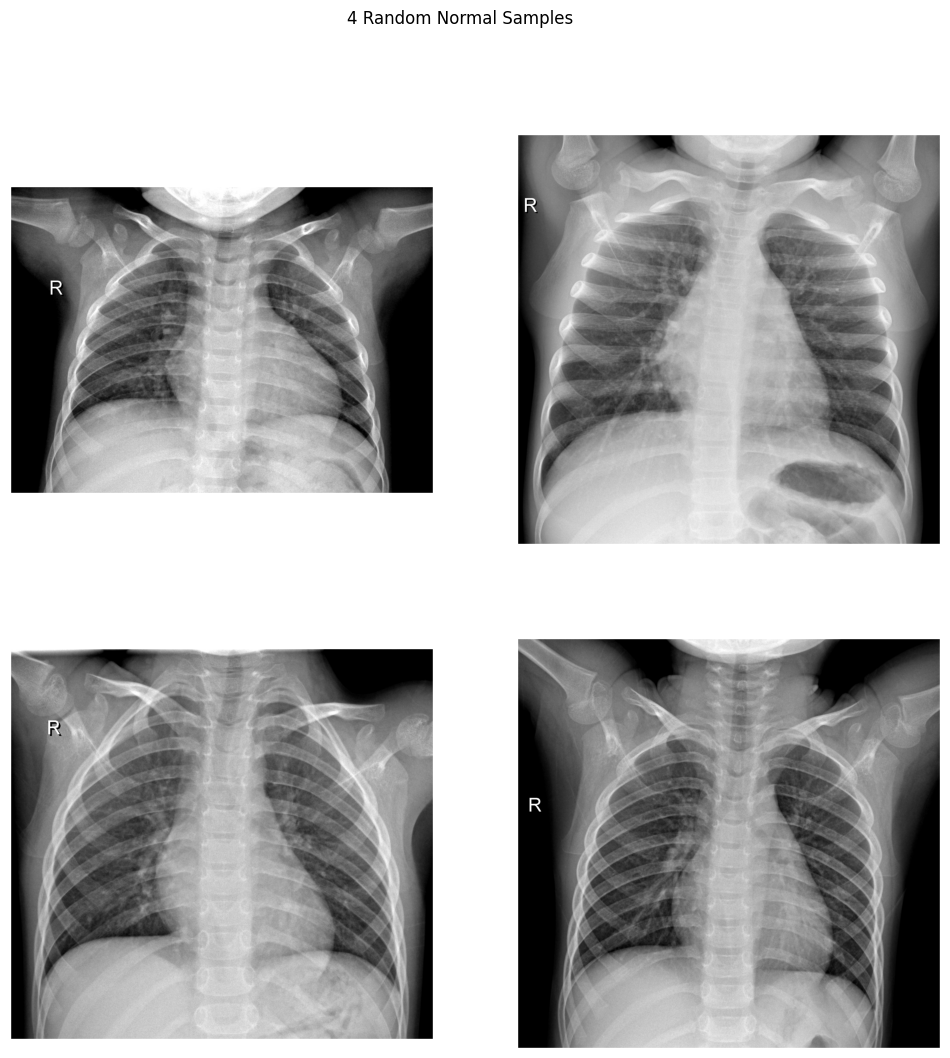

In [10]:
# Build a 2 x 2 figure
rows, columns = 2, 2
fig, axes = plt.subplots(rows, columns)

# Choose random indices for image selection
norm_indices = np.random.choice(len(image_paths_norm), rows * columns)
pn_indices = np.random.choice(len(image_paths_pn), rows * columns)

# Make a list with images to plot
imgs_to_plot_norm = [image_paths_norm[i] for i in norm_indices]
imgs_to_plot_pn = [image_paths_pn[i] for i in pn_indices]

# Variable used for indending through the image list
current_index = 0

# Set figure title
fig.suptitle('4 Random Normal Samples')

# Plot normal images
for i in range(rows):
    for j in range(columns):
        img = load_img(imgs_to_plot_norm[current_index])
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        current_index +=1

plt.show()

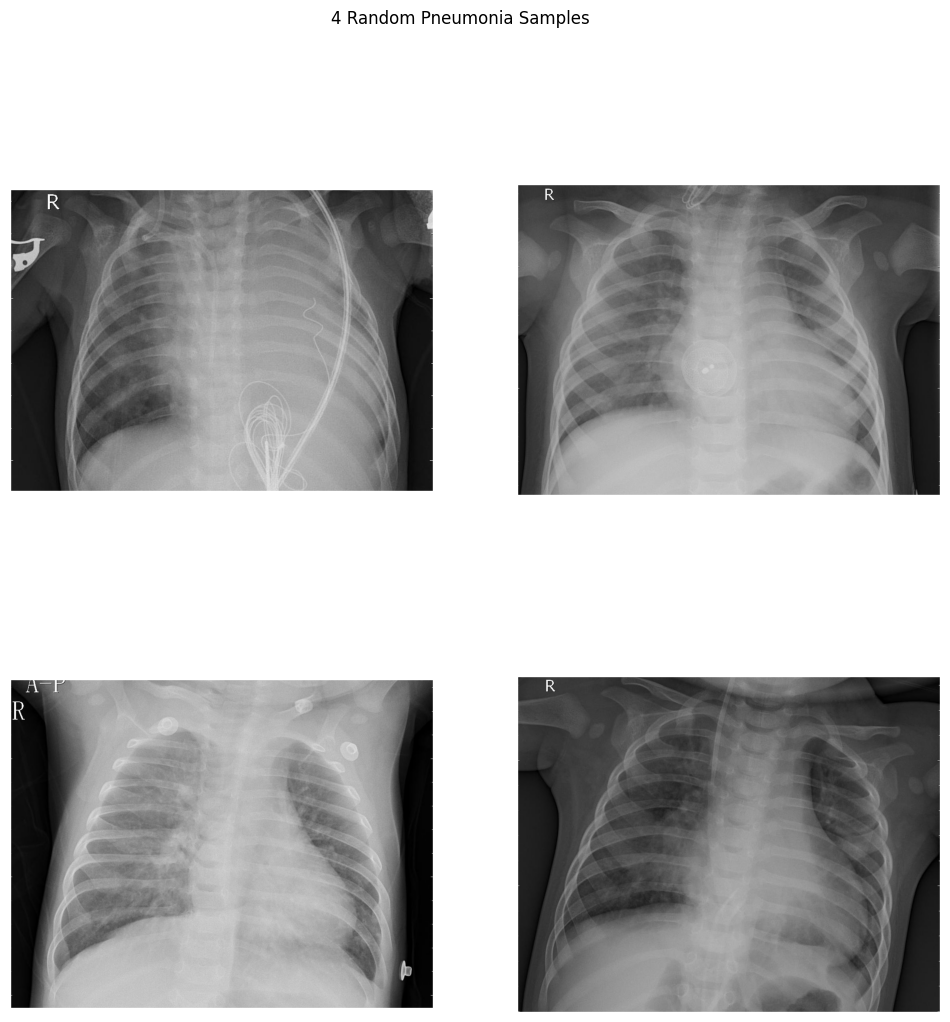

In [11]:
fig, axes = plt.subplots(rows, columns)

current_index = 0

# Set figure title
fig.suptitle('4 Random Pneumonia Samples')

# Plot pneumonia images
for i in range(rows):
    for j in range(columns):
        img = load_img(imgs_to_plot_pn[current_index])
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        current_index +=1

plt.show()

Typically, pneumonia is characterized by consolidations in the alveoli, often resulting from bacterial infections and fluid accumulation. While the distinctions between healthy and pneumonia-affected X-rays are usually quite apparent, in some cases, these differences might be less pronounced.

Next, we'll partition our image paths and labels into training, validation, and test sets, serving distinct purposes:
1. **Training data** is used to adjust the network's weights to enhance performance.
2. **Validation data** helps fine-tune hyperparameters, aiming for low loss, high accuracy, and avoidance of overfitting.
3. **Test data** provides a final check on performance to ensure the model does not merely perform well on the validation data due to overfitting.

I am not adhering to the data splits suggested by the dataset's original publisher, as those configurations did not yield satisfactory results. Instead of continuing with an ineffective approach, I've chosen to create new splits.

For the data division, I use scikit-learn's `train_test_split` method. This method typically splits the data into training and test sets. I further divide the test set to create a validation set, splitting the initial test set in half. This results in a data distribution of 70% for training and 15% each for validation and test.

In [12]:
from sklearn.model_selection import train_test_split

# Divide the image path & label arrays into train & test sets. This is done without loading images to save memory
X_train_dir, X_test_dir, y_train, y_test = \
                                           train_test_split(image_paths, labels, test_size=0.3)

# Divide the test set into validation (for use during training) and test (for post-training evaulation) sets
X_val_dir, y_val = X_test_dir[:len(X_test_dir) // 2], \
                   y_test[:len(y_test) // 2]

X_test_dir, y_test = X_test_dir[len(X_test_dir) // 2:], \
                     y_test[len(y_test) // 2:]

I'll be using an ImageDataGenerator object to feed data into the model. Since we have image paths rather than direct image arrays, the flow method is unsuitable. Instead, we'll utilize the flow_from_dataframe method. This approach requires DataFrames with image paths listed under the "filename" column and their corresponding labels under the "class" column.

Next, we'll construct DataFrames for each dataset set.

In [13]:
# Create DataFrames for the image generator
train_df = pd.DataFrame(np.transpose([X_train_dir, y_train]), columns=['filename', 'class'])

val_df = pd.DataFrame(np.transpose([X_val_dir, y_val]), columns=['filename', 'class'])

test_df = pd.DataFrame(np.transpose([X_test_dir, y_test]),  columns=['filename', 'class'])

We will set up ImageDataGenerator objects to facilitate batch processing and incorporate data augmentation to mitigate overfitting. Data augmentation will apply only to the training data using the *datagen* object, while the validation and test data will undergo simple rescaling to the [0, 1] range using the *test_datagen* object.

I selected data augmentation parameters that ensure the transformed images remain realistic and representative of what the model might encounter in actual usage.

Next, I will establish *DataFrameIterator* objects through the *flow_from_dataframe* method, with specifications for:
1. Target image size (512 x 512).
2. Color mode (grayscale).
3. Batch size (64).
4. Class mode (binary).
5. Shuffling (enabled for training data and disabled for validation and test data).

These *DataFrameIterator* objects will handle loading and processing the images from the specified filenames, resizing them, converting string labels to binary (with "Pneumonia" as 1 and "Normal" as 0), and delivering batches of 64 image-label pairs.

In [14]:
BATCH_SIZE = 64

datagen = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1,
                             height_shift_range=0.05,
                             width_shift_range=0.05,
                             rotation_range=5)


test_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = datagen.flow_from_dataframe(train_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=True)

val_gen = test_datagen.flow_from_dataframe(val_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

test_gen = test_datagen.flow_from_dataframe(test_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

Found 4099 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.


To enhance the efficiency of the input pipeline, I've also implemented *tf.Dataset* objects. I utilized the *prefetch* method from the *tf.Dataset* class to slightly speed up the training process.

Reading images from the disk often creates a significant bottleneck for the model. While my method isn't perfect, it reduces the time per epoch by approximately 20-30 seconds, making the training process a bit faster.

In [15]:
# Declare TensorFlow Datasets for more efficient training
train_data = tf.data.Dataset.from_generator(lambda: train_gen,
                                            output_types=(tf.float32, tf.int32),
                                            output_shapes=([None, 512, 512, 1], [None, ]))

val_data = tf.data.Dataset.from_generator(lambda: val_gen,
                                          output_types=(tf.float32, tf.int32),
                                          output_shapes=([None, 512, 512, 1], [None, ]))

test_data = tf.data.Dataset.from_generator(lambda: test_gen,
                                           output_types=(tf.float32, tf.int32),
                                           output_shapes=([None, 512, 512, 1], [None, ]))

Now, let's evaluate the effectiveness of our data augmentation by examining how our training generator operates. We'll load a few images from the disk, process them using the generator's flow method (which accepts image arrays), and display both the original and augmented images in RGB. This will demonstrate that the augmented images maintain a realistic appearance, suitable for training purposes.

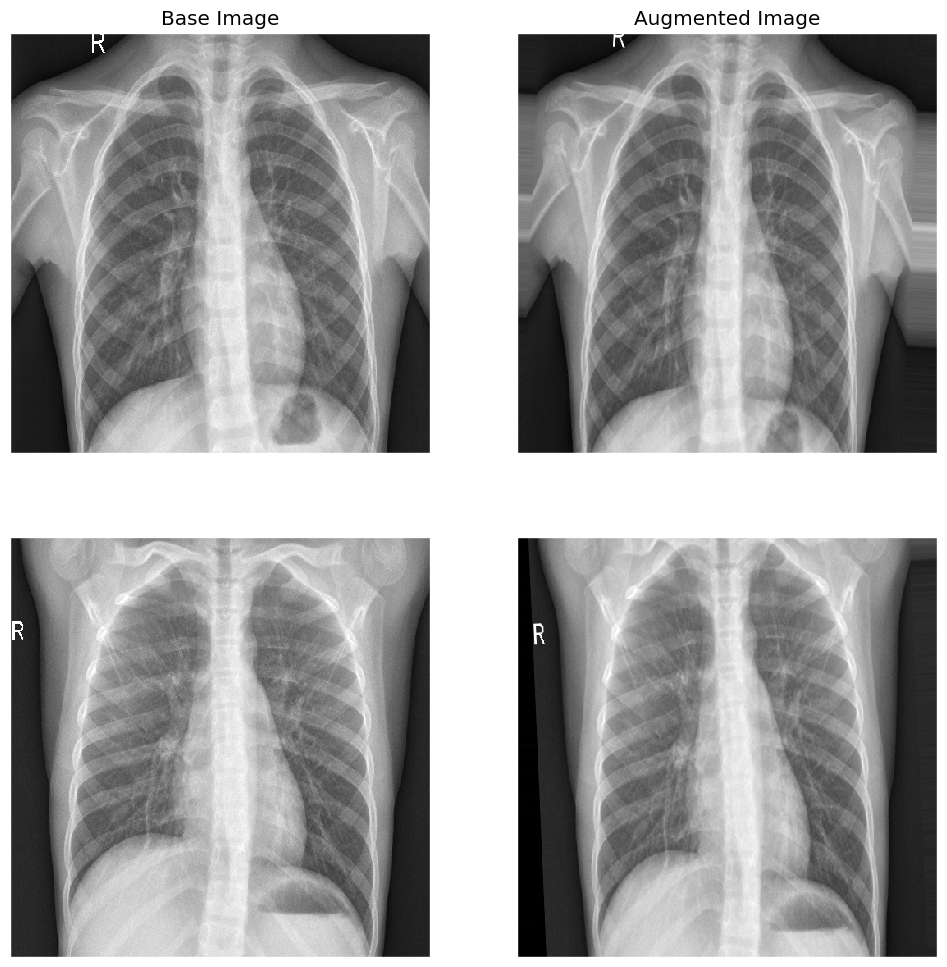

In [16]:
images_to_augment = []

for image_path in image_paths[:4]:
    image = load_img(image_path, target_size=(512, 512))
    image = img_to_array(image)
    images_to_augment.append(image)

images_to_augment = np.array(images_to_augment)

images_augmented = next(datagen.flow(x=images_to_augment,
                                batch_size=10,
                                shuffle=False))
fig, axes = plt.subplots(2, 2)

for i in range(2):
    axes[i, 0].imshow(array_to_img(images_to_augment[i]),
                      interpolation='nearest')

    axes[i, 1].imshow(array_to_img(images_augmented[i]),
                      interpolation='nearest')

    axes[i, 0].set_xticks([])
    axes[i, 1].set_xticks([])

    axes[i, 0].set_yticks([])
    axes[i, 1].set_yticks([])

columns = ['Base Image', 'Augmented Image']
for ax, column in zip(axes[0], columns):
    ax.set_title(column)

plt.show()

And below is how I used the *prefetch* method of the *tf.Dataset* class that I talked about.

We've now arrived at the stage of creating the model. The architecture outlined below is the result of various tests and iterations. I've documented the outcomes of these tests in CSV files, which we'll review later to illustrate the process of selecting this particular model.

Let's proceed by defining the model, and then we will generate and view a summary and a visual representation of its architecture.

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def feed_data(dataset):
    """Prepare dataset for model training by enabling prefetching."""
    return dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

def conv_block(x, filters, block_number):
    """Build a convolutional block with Conv2D, MaxPool2D, and Dropout."""
    x = layers.Conv2D(filters=filters, kernel_size=3, activation='relu', padding='same', name=f'conv2d_{block_number}')(x)
    x = layers.MaxPool2D(pool_size=2, name=f'maxpool2d_{block_number}')(x)
    x = layers.Dropout(0.1, name=f'dropout_{block_number}')(x)
    return x

def create_model():
    """
    Create a Keras CNN model for binary classification of images with shape (512, 512).

    Returns:
        model (tf.keras.Model): Compiled CNN model.
    """
    input_layer = layers.Input(shape=(512, 512, 1), name='input')
    x = input_layer

    # Create multiple convolutional blocks with increasing filters
    filter_sizes = [64, 96, 128, 160, 192, 224, 256]
    for i, filters in enumerate(filter_sizes, 1):
        x = conv_block(x, filters, i)

    # Global pooling and output layer
    x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)
    output = layers.Dense(units=1, activation='sigmoid', name='output')(x)

    # Model creation
    model = Model(input_layer, output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [18]:
# Create a Model object
model = create_model()

# See the layer and parameter summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 512, 512, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 64)      640       
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 dropout_1 (Dropout)         (None, 256, 256, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 96)      55392     
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 128, 128, 96)      0         
                                                                 
 dropout_2 (Dropout)         (None, 128, 128, 96)      0     

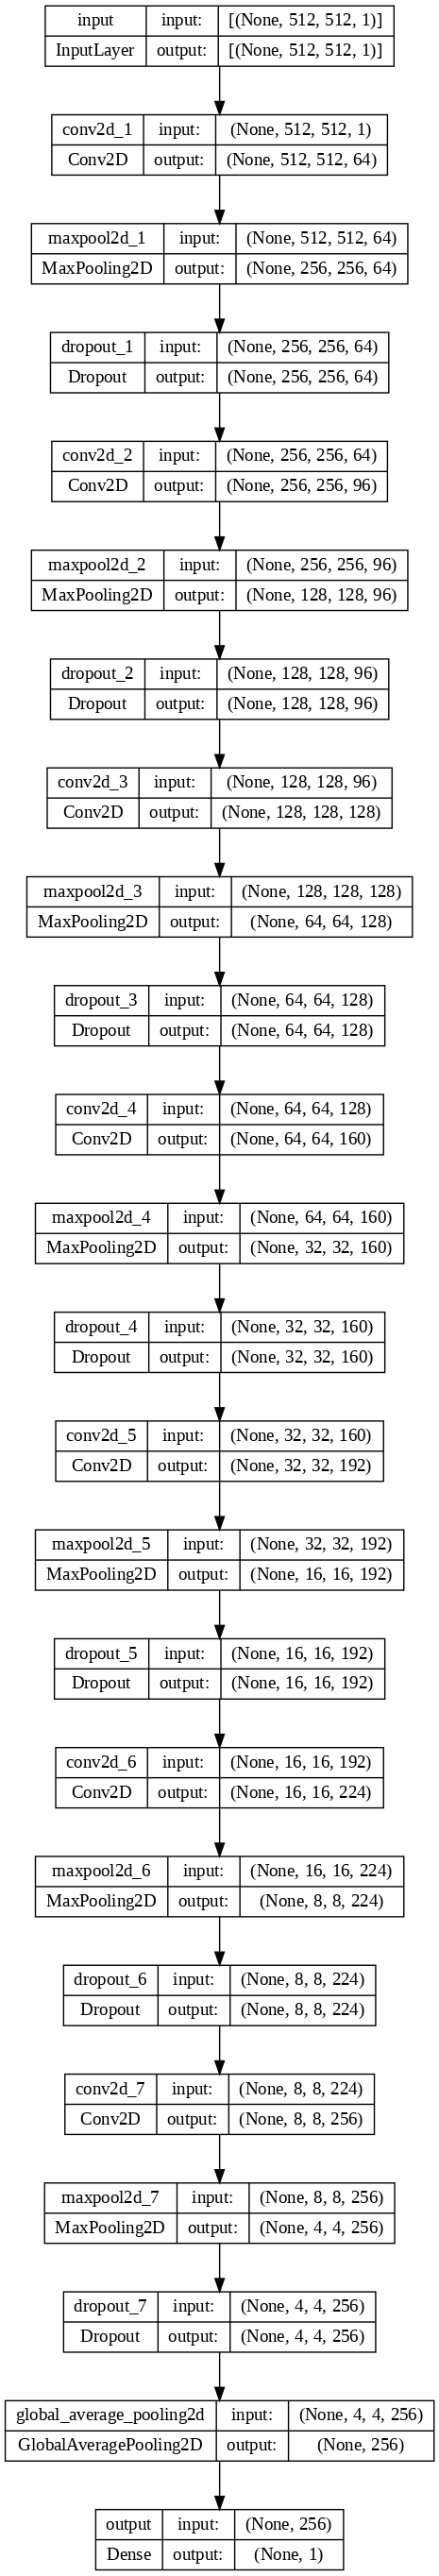

In [19]:
# See graphical representation of the model
plot_model(model, show_shapes=True, dpi=100)  # Default is usually 96 DPI

Below, I've set up three callbacks for training: a LearningRateScheduler, a CSVLogger, and a ModelCheckpoint. The CSVLogger records model training results, and the ModelCheckpoint saves the model weights after each epoch. These last two are particularly useful as they allow for saving results and models across multiple notebook runs. For this demonstration, I'm declaring the CSVLogger and ModelCheckpoint but won't be using them since the training and testing have already been completed.

In [20]:
def lr_decay(epoch):
    """Calculate the learning rate for a given epoch based on exponential decay."""
    initial_lr = 0.001
    return initial_lr * np.exp(-0.1 * epoch)

# Set up learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_decay, verbose=1)

# Set up CSV logger to record training results
csv_logger = CSVLogger('training_log.csv', append=True)

# Set up model checkpointing to save the best model based on validation loss
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Path and filename with .keras extension
    save_best_only=True,          # Save only when improvement in validation loss is seen
    monitor='val_loss',           # Monitor validation loss to determine improvement
    mode='min',                   # Minimize validation loss
    verbose=1                     # Log details when a new best is saved
)

Next, I calculated the number of training and validation steps by dividing the number of samples by the batch size and then rounding down the result. By rounding down, not every image is used in the training process. This was a deliberate decision, especially relevant in scenarios where I tested models without data augmentation. Without augmentation, rounding down helps prevent the model from being trained on duplicate images, which I aimed to avoid.

In [21]:
# Calculate the number of steps for training and validation
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE

Below, I commence training will validation data and callbacks. I've commented this part out because training takes a long time and because I have the results anyway.

In [ ]:
history = model.fit(feed_data(train_data),
                    epochs=2,
                    steps_per_epoch=train_steps,
                    validation_data=(feed_data(val_data)),
                    validation_steps=val_steps,
                    shuffle=False,
                    callbacks=[lr_scheduler, csv_logger, model_checkpoint])

Epoch 1/30
13/13 [==============================] - 12s 910ms/step - loss: 0.3200 - accuracy: 75.1231
Epoch 2/30
13/13 [==============================] - 12s 910ms/step - loss: 0.3614 - accuracy: 78.8721
Epoch 3/30
13/13 [==============================] - 12s 910ms/step - loss: 0.3856 - accuracy: 81.1371
Epoch 4/30
13/13 [==============================] - 12s 910ms/step - loss: 0.4028 - accuracy: 82.7442
Epoch 5/30
13/13 [==============================] - 12s 910ms/step - loss: 0.4162 - accuracy: 83.9908
Epoch 6/30
13/13 [==============================] - 12s 910ms/step - loss: 0.4270 - accuracy: 85.0092
Epoch 7/30
13/13 [==============================] - 12s 910ms/step - loss: 0.4363 - accuracy: 85.8704
Epoch 8/30
13/13 [==============================] - 12s 910ms/step - loss: 0.4442 - accuracy: 86.6163
Epoch 9/30
13/13 [==============================] - 12s 910ms/step - loss: 0.4513 - accuracy: 87.2743
Epoch 10/30
13/13 [==============================] - 12s 910ms/step - loss: 0.4576

Next, I evaluated the model on the test dataset that was previously defined, including tests on data with and without augmentation to compare results. I also calculated precision and recall for both the augmented and non-augmented test data. The outcomes were quite similar for both scenarios, indicating that the model effectively learned the underlying distribution of the data.

In [ ]:
# Evaluate the model on the test set
test_steps = test_gen.samples // BATCH_SIZE
model.evaluate(test_data, steps=test_steps)

# Declare an image generator on test data for augmented images
test_aug_gen = datagen.flow_from_dataframe(test_df,
                                           target_size=(512, 512),
                                           color_mode='grayscale',
                                           batch_size=BATCH_SIZE,
                                           class_mode='binary',
                                           shuffle=False)

test_aug_data = tf.data.Dataset.from_generator(lambda: test_aug_gen,
                                           output_types=(tf.float32, tf.int32),
                                           output_shapes=([None, 512, 512, 1], [None, ]))

# Evaluate the model on augmented test data
test_aug_steps = test_aug_gen.samples // BATCH_SIZE
model.evaluate(test_aug_data, steps=test_aug_steps)

In [ ]:
# Calculate precision and recall based on  test data

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

predictions = model.predict(test_data, steps=test_steps).flatten()
y_true = test_gen.classes[:len(predictions)]

precision.update_state(y_true, predictions)
recall.update_state(y_true, predictions)

In [ ]:
print('Precision with base test data:', precision.result().numpy())
print('Recall with base test data:', recall.result().numpy())

In [ ]:
# # Calculate precision and recall based on augmented test data
# precision.reset_states()
# recall.reset_states()

predictions_aug = model.predict(test_aug_data, steps=test_steps).flatten()
y_true = test_gen.classes[:len(predictions_aug)]

precision.update_state(y_true, predictions_aug)
recall.update_state(y_true, predictions_aug)

In [ ]:
print('Precision with augmented test data:', precision.result().numpy())
print('Recall with augmented test data:', recall.result().numpy())

And a confusion matrix for a better look at true and false prediction counts.

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true, predictions > 0.5)

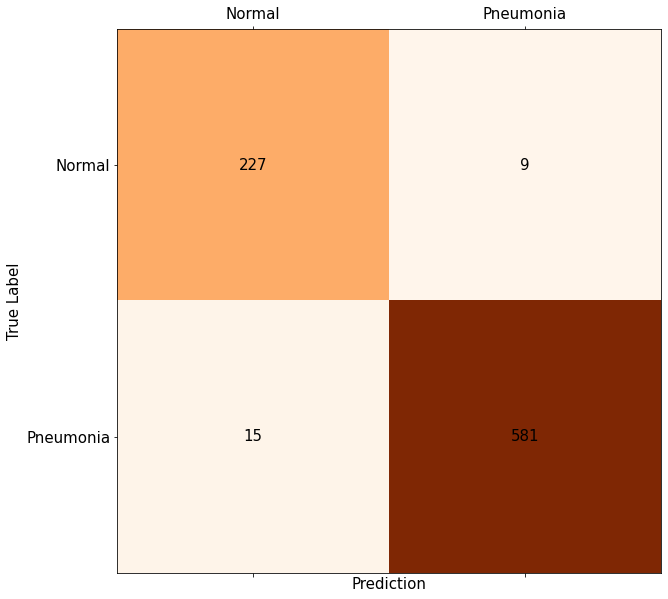

In [ ]:
fig, ax = plt.subplots()

ax.matshow(confusion_mat, cmap=plt.cm.Oranges)

ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')

tick_labels = ['Normal', 'Pneumonia']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat[i, j],
               ha='center', va='center')

plt.show()

To give you an idea of how the model performs, let's also plot a few images along with their predictions and true labels.

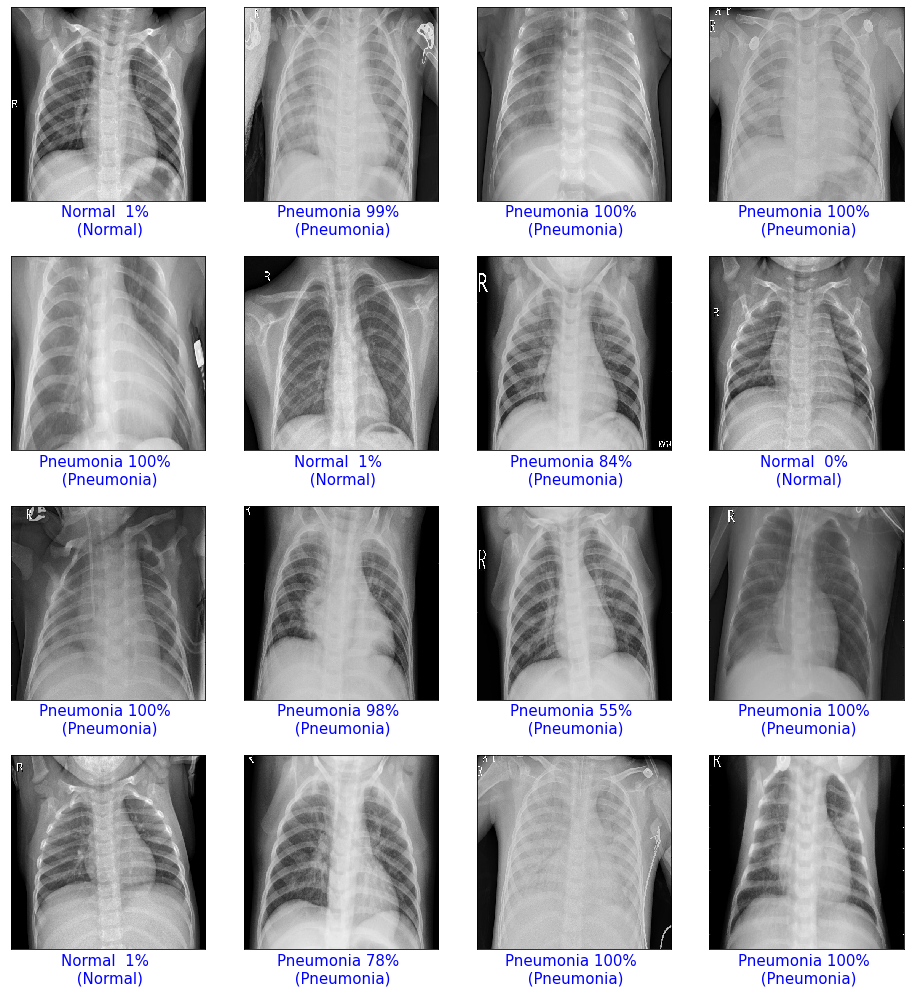

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img

def plot_image(image, prediction, label):
    """
    Plot images along with predictions and true labels

    Arguments:
        image (4-D array): The image to visualize
        prediction (2-D array): Model's prediction on the image
        label (1-D array): True label of the image
    """

    label_names = ['Normal', 'Pneumonia']

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(array_to_img(image * 255), interpolation='nearest', cmap='gray')

    if prediction <= 0.5:
        predicted_label = 0
    else:
        predicted_label = 1

    if predicted_label == label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% \n ({})".format(label_names[predicted_label], 100 * prediction[0], label_names[label]), color=color)

In [ ]:
images, labels = next(iter(test_data))
y_pred = model.predict(images)
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2.2*2*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(images[i], y_pred[i], labels[i])
plt.show()

Above, I've used 0.5 as the decision threshold. This threshold is also used during training for accuracy computations.

You can adjust the decision threshold in the [0, 1] range to tweak the confidence with which the model will make predictions. Needless to say, this will change how well the model performs. For a better look, let's see how the metrics change with a few thresholds values.

In [ ]:
def calculate_metrics(predictions, labels, threshold):
    """
    Calculate precision, recall, and binary accuracy given a dataset

    Arguments:
        predictions (1-D array): Model predictions
        labels (1-D array): True labels
        threshold (float): The metrics' decision threshold

    Returns:
        Mean of metrics on all batches of data
    """

    precision = tf.keras.metrics.Precision(thresholds=threshold)
    recall = tf.keras.metrics.Recall(thresholds=threshold)
    binary_accuracy = tf.keras.metrics.BinaryAccuracy(threshold=threshold)

    precision.update_state(y_true, predictions)
    recall.update_state(y_true, predictions)
    binary_accuracy.update_state(y_true, predictions)

    return precision.result().numpy(), recall.result().numpy(), binary_accuracy.result().numpy()

In [ ]:
thresholds = np.linspace(0, 1, 100)

precisions, recalls, binary_accuracies = [], [], []

In [ ]:
for threshold in thresholds:
    precision, recall, binary_accuracy = calculate_metrics(predictions, y_true, threshold)

    precisions.append(precision)
    recalls.append(recall)
    binary_accuracies.append(binary_accuracy)

In [ ]:
def plot_metrics(precisions, recalls, accuracies, thresholds):
    """
    Plot the dependency of metrics on threshold values

    Arguments:
        precisions (1-D array): Precisions calculated on thresholds
        recalls (1-D array): Recalls calculated on thresholds
        accuraries (1-D array): Accuracies calculated on thresholds
        thresholds (1-D array): Thresholds upon which metrics were evaluated

    """

    plt.plot(thresholds, precisions, label='Precison')
    plt.plot(thresholds, recalls, '--', label='Recall')
    plt.plot(thresholds, accuracies,'-.', label='Accuracy')

    plt.xticks(np.linspace(0, 1, 10))
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.ylim([0.7, 1])
    plt.grid()
    plt.legend()
    plt.title('The Dependence Of Metric Scores On The Decision Threshold')
    plt.show()

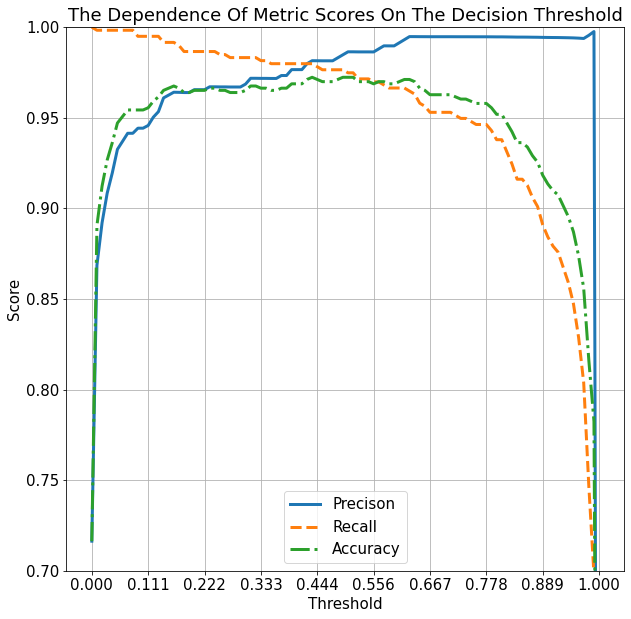

In [ ]:
plot_metrics(precisions, recalls, binary_accuracies, thresholds)

As we can see, precision is low with low thresholds and high with high thresholds. The dependence for recall is inverse - it's the highest when the threshold is 0 and the lowest when it's 1. As for accuracy, it's somewhat dependent on precision and recall, so its highest scores are somewhere in the middle.